In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/5013 - Project/m5-forecasting-uncertainty

/content/drive/.shortcut-targets-by-id/129se4YWr7uxgjWW5UxAKQMxQvb6wH99Q/5013 - Project/m5-forecasting-uncertainty


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc

In [4]:
def reduce_mem(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
def preprocess_sales(sales, start=1400, upper=1970):
    if start is not None:
        print("dropping...")
        to_drop = [f"d_{i+1}" for i in range(start-1)]
        print(sales.shape)
        sales.drop(to_drop, axis=1, inplace=True)
        print(sales.shape)
    #=======
    print("adding...")
    new_columns = ['d_%i'%i for i in range(1942, upper, 1)]
    for col in new_columns:
        sales[col] = np.nan
    print("melting...")
    sales = sales.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id","scale","start"],
                        var_name='d', value_name='demand')

    print("generating order")
    if start is not None:
        skip = start
    else:
        skip = 1
    sales["nb"] =sales.index // 42840 + skip
    return sales

In [6]:
def preprocess_calendar(calendar):
    global maps, mods
    calendar["event_name"] = calendar["event_name_1"]
    calendar["event_type"] = calendar["event_type_1"]

    map1 = {mod:i for i,mod in enumerate(calendar['event_name'].unique())}
    calendar['event_name'] = calendar['event_name'].map(map1)
    map2 = {mod:i for i,mod in enumerate(calendar['event_type'].unique())}
    calendar['event_type'] = calendar['event_type'].map(map2)
    calendar['nday'] = calendar['date'].str[-2:].astype(int)
    maps["event_name"] = map1
    maps["event_type"] = map2
    mods["event_name"] = len(map1)
    mods["event_type"] = len(map2)
    calendar["wday"] -=1
    calendar["month"] -=1
    calendar["year"] -= 2011
    mods["month"] = 12
    mods["year"] = 6
    mods["wday"] = 7
    mods['snap_CA'] = 2
    mods['snap_TX'] = 2
    mods['snap_WI'] = 2

    calendar.drop(["event_name_1", "event_name_2", "event_type_1", "event_type_2", "date", "weekday"], 
                  axis=1, inplace=True)
    return calendar

In [7]:
def generate_dataset(categorize=False ,start=1400, upper= 1970):
    global maps, mods
    print("loading calendar...")
    calendar = pd.read_csv("./data/calendar.csv")
    print("loading sales...")
    sales = pd.read_csv("./data/sales.csv")
    cols = ["item_id", "dept_id", "cat_id","store_id","state_id"]
    if categorize:
        for col in cols:
            temp_dct = {mod:i for i, mod in enumerate(sales[col].unique())}
            mods[col] = len(temp_dct)
            maps[col] = temp_dct
        for col in cols:
            sales[col] = sales[col].map(maps[col])
        #

    sales =preprocess_sales(sales, start=start, upper= upper)
    calendar = preprocess_calendar(calendar)
    calendar = reduce_mem(calendar)
    print("merge with calendar...")
    sales = sales.merge(calendar, on='d', how='left')
    del calendar

    print("reordering...")
    sales.sort_values(by=["id","nb"], inplace=True)
    print("re-indexing..")
    sales.reset_index(inplace=True, drop=True)
    gc.collect()

    sales['n_week'] = (sales['nb']-1)//7
    sales["nday"] -= 1
    mods['nday'] = 31
    sales = reduce_mem(sales)
    gc.collect()
    return sales

In [8]:
%%time
START = 1400; UPPER = 1970;
maps = {}
mods = {}
sales = generate_dataset(categorize=True ,start=START, upper= UPPER)

loading calendar...
loading sales...
dropping...
(42840, 1949)
(42840, 550)
adding...
melting...
generating order
Mem. usage decreased to  0.04 Mb (78.4% reduction)
merge with calendar...
reordering...
re-indexing..
Mem. usage decreased to 1001.37 Mb (59.8% reduction)
CPU times: user 46.3 s, sys: 4.16 s, total: 50.5 s
Wall time: 1min


In [9]:
sales["x"] = sales["demand"] / sales["scale"]

In [10]:
LAGS = [28, 35, 42, 49, 56, 63]
FEATURES = []
for lag in tqdm(LAGS):
    sales[f"x_{lag}"] = sales.groupby("id")["x"].shift(lag)
    FEATURES.append(f"x_{lag}")
#

100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


In [11]:
print(sales.shape)
sales = sales.loc[sales.nb>sales.start]
print(sales.shape)

(24418800, 29)
(24268220, 29)


In [12]:
nb = sales['nb'].values
MAX_LAG = max(LAGS)
tra_mask = np.logical_and(nb>START + MAX_LAG, nb<=1941)
val_mask = np.logical_and(nb>1913, nb<=1941)
test_mask = np.logical_and(nb>1941, nb<=1969)

In [13]:
scale = sales['scale'].values
ids = sales['id'].values
ys = sales['x'].values
Z = sales[FEATURES].values

In [14]:
sv = scale[val_mask]
se = scale[test_mask]
ids = ids[test_mask]
ids = ids.reshape((-1, 28))

In [15]:
ca = sales[['snap_CA']].values
tx = sales[['snap_TX']].values
wi = sales[['snap_WI']].values
wday = sales[['wday']].values
month = sales[['month']].values
year = sales[['year']].values
event = sales[['event_name']].values
nday = sales[['nday']].values

In [16]:
item = sales[['item_id']].values
dept = sales[['dept_id']].values
cat = sales[['cat_id']].values
store = sales[['store_id']].values
state = sales[['state_id']].values

In [17]:
def form_data(mask):
    x = {"snap_CA":ca[mask], "snap_TX":tx[mask], "snap_WI":wi[mask], "wday":wday[mask], 
         "month":month[mask], "year":year[mask], "event":event[mask], "nday":nday[mask], 
         "item":item[mask], "dept":dept[mask], "cat":cat[mask], "store":store[mask], 
         "state":state[mask], "num":Z[mask]}
    t = ys[mask]
    return x, t

In [18]:
xt, yt = form_data(tra_mask) #train
xv, yv = form_data(val_mask) # val
xe, ye = form_data(test_mask) # test

In [19]:
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf


## Baseline model

In [20]:
def qloss(y_true, y_pred):
    # Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true - y_pred
    v = tf.maximum(q*e, (q-1)*e)
    return K.mean(v)

In [21]:
def wqloss(y_true, y_pred):
    # Weighted Pinball loss for multiple quantiles
    qs = [0.005, 0.025, 0.165, 0.250, 0.500, 0.750, 0.835, 0.975, 0.995]
    q = tf.constant(np.array([qs]), dtype=tf.float32)
    e = y_true[:, :, :1] - y_pred
    v = tf.maximum(q * e, (q - 1) * e)
    psl = tf.reduce_mean(v, axis=[1, 2])
    weights = y_true[:, 0, 1] / K.sum(y_true[:, 0, 1])
    return tf.reduce_sum(psl * weights)

In [22]:
def buildup_model(n_in):
    
    num = L.Input((n_in,), name="num")
    
    ca = L.Input((1,), name="snap_CA")
    tx = L.Input((1,), name="snap_TX")
    wi = L.Input((1,), name="snap_WI")
    wday = L.Input((1,), name="wday")
    month = L.Input((1,), name="month")
    year = L.Input((1,), name="year")
    event = L.Input((1,), name="event")
    nday = L.Input((1,), name="nday")
    item = L.Input((1,), name="item")
    dept = L.Input((1,), name="dept")
    cat = L.Input((1,), name="cat")
    store = L.Input((1,), name="store")
    state = L.Input((1,), name="state")
    inp = {"snap_CA":ca, "snap_TX":tx, "snap_WI":wi, "wday":wday, 
           "month":month, "year":year, "event":event, "nday":nday,
           "item":item, "dept":dept, "cat":cat, "store":store, 
           "state":state, "num":num} 
    #
    ca_ = L.Embedding(mods["snap_CA"], mods["snap_CA"], name="ca_3d")(ca)
    tx_ = L.Embedding(mods["snap_TX"], mods["snap_TX"], name="tx_3d")(tx)
    wi_ = L.Embedding(mods["snap_WI"], mods["snap_WI"], name="wi_3d")(wi)
    wday_ = L.Embedding(mods["wday"], mods["wday"], name="wday_3d")(wday)
    month_ = L.Embedding(mods["month"], mods["month"], name="month_3d")(month)
    year_ = L.Embedding(mods["year"], mods["year"], name="year_3d")(year)
    event_ = L.Embedding(mods["event_name"], mods["event_name"], name="event_3d")(event)
    nday_ = L.Embedding(mods["nday"], mods["nday"], name="nday_3d")(nday)
    item_ = L.Embedding(mods["item_id"], 10, name="item_3d")(item)
    dept_ = L.Embedding(mods["dept_id"], mods["dept_id"], name="dept_3d")(dept)
    cat_ = L.Embedding(mods["cat_id"], mods["cat_id"], name="cat_3d")(cat)
    store_ = L.Embedding(mods["store_id"], mods["store_id"], name="store_3d")(store)
    state_ = L.Embedding(mods["state_id"], mods["state_id"], name="state_3d")(state)
    
    p = [ca_, tx_, wi_, wday_, month_, year_, event_, nday_, item_, dept_, cat_, store_, state_]
    emb = L.Concatenate(name="embds")(p)
    context = L.Flatten(name="context")(emb)
    
    x = L.Concatenate(name="x1")([context, num])
    x = L.Dense(500, activation="relu", name="d1")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m1")([x, context])
    x = L.Dense(500, activation="relu", name="d2")(x)
    x = L.Dropout(0.3)(x)
    x = L.Concatenate(name="m2")([x, context])
    x = L.Dense(500, activation="relu", name="d3")(x)
    preds = L.Dense(9, activation="linear", name="preds")(x)
    model = M.Model(inp, preds, name="M1")
    model.compile(loss=qloss, optimizer="adam")
    return model

In [23]:
net = buildup_model(len(FEATURES))
ckpt = ModelCheckpoint("w.h5", monitor='val_loss', verbose=1, save_best_only=True,mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)
es = EarlyStopping(monitor='val_loss', patience=3)
print(net.summary())

Model: "M1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 snap_CA (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 snap_TX (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 snap_WI (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 wday (InputLayer)              [(None, 1)]          0           []                               
                                                                                                 

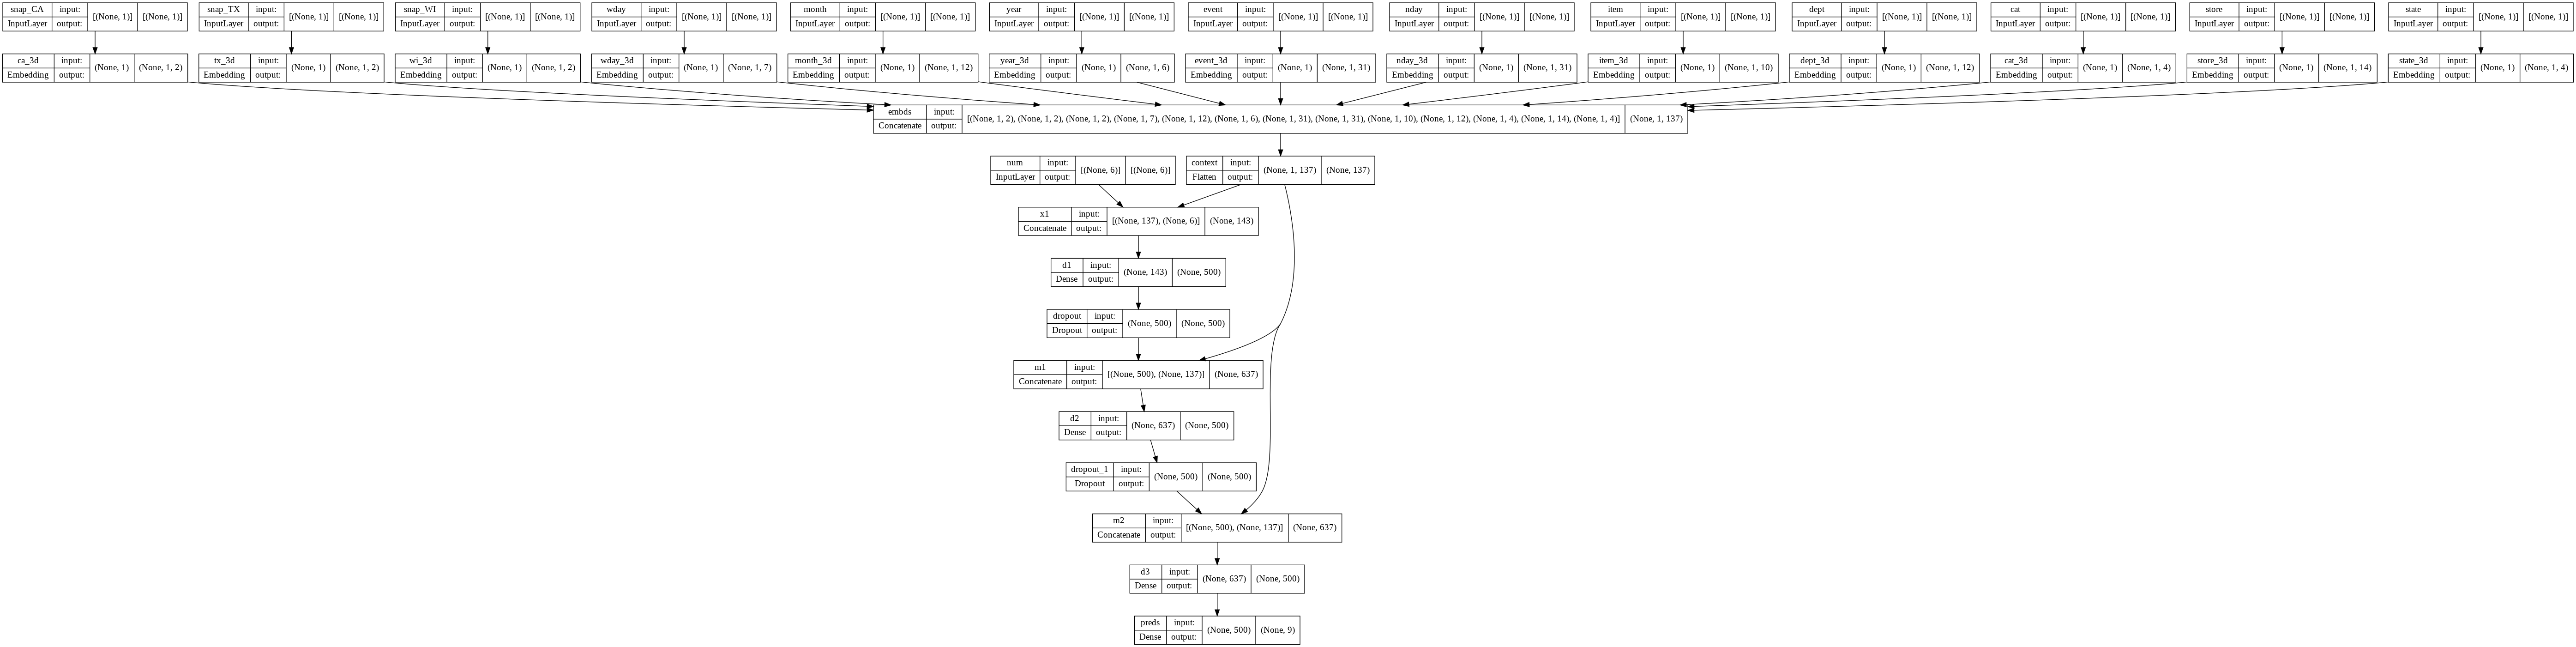

In [24]:
from keras.utils.vis_utils import plot_model
plot_model(net, 'Quantile-Regression-with-Keras.png', show_shapes=True)

In [25]:
net.fit(xt, yt, batch_size=50_000, epochs=20, validation_data=(xv, yv), callbacks=[ckpt, reduce_lr, es])

Epoch 1/20
408/408 [==============================] - ETA: 0s - loss: 0.2115
Epoch 1: val_loss improved from inf to 0.22822, saving model to w.h5
408/408 [==============================] - 93s 212ms/step - loss: 0.2115 - val_loss: 0.2282 - lr: 0.0010
Epoch 2/20
408/408 [==============================] - ETA: 0s - loss: 0.2007
Epoch 2: val_loss improved from 0.22822 to 0.22445, saving model to w.h5
408/408 [==============================] - 86s 210ms/step - loss: 0.2007 - val_loss: 0.2244 - lr: 0.0010
Epoch 3/20
408/408 [==============================] - ETA: 0s - loss: 0.1982
Epoch 3: val_loss improved from 0.22445 to 0.22225, saving model to w.h5
408/408 [==============================] - 85s 210ms/step - loss: 0.1982 - val_loss: 0.2222 - lr: 0.0010
Epoch 4/20
408/408 [==============================] - ETA: 0s - loss: 0.1958
Epoch 4: val_loss improved from 0.22225 to 0.22022, saving model to w.h5
408/408 [==============================] - 85s 209ms/step - loss: 0.1958 - val_loss: 0.22

In [26]:
nett = buildup_model(len(FEATURES))
nett.load_weights("w.h5")

In [27]:
pv = nett.predict(xv, batch_size=50_000, verbose=1)
pe = nett.predict(xe, batch_size=50_000, verbose=1)

24/24 [==============================] - 1s 55ms/step


In [28]:
nett.evaluate(xv, yv, batch_size=50_000)

24/24 [==============================] - 2s 58ms/step - loss: 0.2114


0.21138779819011688

In [29]:
pv = pv.reshape((-1, 28, 9))
pe = pe.reshape((-1, 28, 9))

In [30]:
sv = sv.reshape((-1, 28))
se = se.reshape((-1, 28))

In [31]:
Yv = yv.reshape((-1, 28))

CA_HOBBIES_1_338


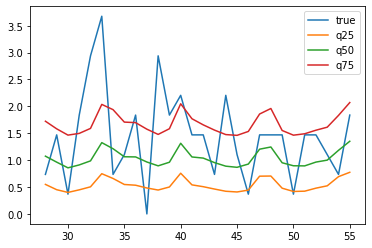

In [32]:
k = np.random.randint(0, 42840)
#k = np.random.randint(0, 200)
print(ids[k, 0])
plt.plot(np.arange(28, 56), Yv[k], label="true")
plt.plot(np.arange(28, 56), pv[k ,:, 3], label="q25")
plt.plot(np.arange(28, 56), pv[k ,:, 4], label="q50")
plt.plot(np.arange(28, 56), pv[k, :, 5], label="q75")
plt.legend(loc="best")
plt.show()

## Prediction

In [33]:
names = [f"F{i+1}" for i in range(28)]

In [34]:
piv = pd.DataFrame(ids[:, 0], columns=["id"])

In [35]:
QUANTILES = ["0.005", "0.025", "0.165", "0.250", "0.500", "0.750", "0.835", "0.975", "0.995"]
VALIDATION = []
EVALUATION = []

for i, quantile in tqdm(enumerate(QUANTILES)):
    t1 = pd.DataFrame(pv[:,:, i]*sv, columns=names)
    t1 = piv.join(t1)
    t1["id"] = t1["id"] + f"_{quantile}_validation"
    t2 = pd.DataFrame(pe[:,:, i]*se, columns=names)
    t2 = piv.join(t2)
    t2["id"] = t2["id"] + f"_{quantile}_evaluation"
    VALIDATION.append(t1)
    EVALUATION.append(t2)

9it [00:00, 24.42it/s]


In [36]:
sub = pd.DataFrame()
sub = sub.append(VALIDATION + EVALUATION)
del VALIDATION, EVALUATION, t1, t2

In [37]:
sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,CA_1_FOODS_0.005_validation,2196.925537,1990.290405,1864.149780,1935.881836,2210.634521,2955.283203,3079.922607,2387.440430,2304.426025,...,2428.981201,3142.140381,3398.802002,2446.071289,2102.960938,2091.100586,2129.816406,2329.467529,3054.776123,3331.751221
1,CA_1_FOODS_1_0.005_validation,165.624054,152.991577,143.991837,159.319901,213.321884,280.984039,266.193604,167.238037,175.961655,...,231.062607,283.204712,234.199478,170.445419,143.571899,159.182709,190.329559,217.971512,294.268372,247.682495
2,CA_1_FOODS_2_0.005_validation,335.043060,289.808777,240.275253,248.882126,305.425446,420.544037,455.287964,393.278931,387.351044,...,342.023132,451.383240,503.819336,388.600677,310.328888,295.513580,268.587952,323.751892,400.624176,463.355835
3,CA_1_FOODS_3_0.005_validation,1495.151611,1306.279419,1227.518066,1265.976318,1487.031006,2025.614014,2124.656982,1596.228638,1509.837280,...,1672.088013,2206.075195,2388.405762,1635.024658,1380.894531,1363.181152,1391.015869,1558.548462,2167.054688,2379.012451
4,CA_1_HOBBIES_0.005_validation,317.915375,286.477722,279.281036,272.142914,317.403473,412.742310,424.471680,319.198120,343.580719,...,341.099518,448.178101,431.782013,356.937195,310.663086,310.526611,304.600800,372.718506,473.380615,468.878571


In [39]:
sub.to_csv("submission_quantile_regression.csv", index=False)